# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data.
We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here.
You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

    8192/11490434 [..............................] - ETA: 0s

 5398528/11490434 [=============>................] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ models:

1. An encoder
2. A decoder
3. An autoencoder (which is just a chain of the encoder and decoder)

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

We will build these models within `_keras_build_fn` so that we can store our encoders and decoders as seperate models and call them from `transform` and `inverse_transform` respectively.

For a background on chaining Functional Models like this, see [All models are callable](https://keras.io/guides/functional_api/#all-models-are-callable-just-like-layers) in the Keras docs.

In [5]:
from typing import Dict, Any

from sklearn.base import TransformerMixin
from scikeras.wrappers import BaseWrapper
from tensorflow.keras.metrics import binary_accuracy


class AutoEncoder(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """
    
    def _keras_build_fn(self, encoding_dim: int, meta: Dict[str, Any]):
        n_features_in = meta["n_features_in_"]

        encoder_input = keras.Input(shape=(n_features_in,))
        encoder_output = keras.layers.Dense(encoding_dim, activation='relu')(encoder_input)
        encoder_model = keras.Model(encoder_input, encoder_output)

        decoder_input = keras.Input(shape=(encoding_dim,))
        decoder_output = keras.layers.Dense(n_features_in, activation='sigmoid', name="decoder")(decoder_input)
        decoder_model = keras.Model(decoder_input, decoder_output)
        
        autoencoder_input = keras.Input(shape=(n_features_in,))
        encoded_img = encoder_model(autoencoder_input)
        reconstructed_img = decoder_model(encoded_img)

        autoencoder_model = keras.Model(autoencoder_input, reconstructed_img)

        self.encoder_model_ = BaseWrapper(encoder_model, predict__verbose=self.predict__verbose)
        self.decoder_model_ = BaseWrapper(decoder_model, predict__verbose=self.predict__verbose)

        return autoencoder_model

    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        X_tf = self.encoder_model_.initialize(X).predict(X)
        self.decoder_model_.initialize(X_tf)
        return self
    
    def score(self, X) -> float:
        reconstructed = self.predict(X)
        return binary_accuracy(X, reconstructed).numpy().mean()

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        return self.encoder_model_.predict(X)

    def inverse_transform(self, X_tf):
        X = self.decoder_model_.predict(X_tf)
        return self.feature_encoder_.inverse_transform(X)

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done.
We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [6]:
autoencoder = AutoEncoder(
    loss="binary_crossentropy",
    encoding_dim=32,
    random_state=0,
    epochs=5,
    batch_size=256,
    fit__verbose=1,
    predict__verbose=0
)

## 4. Training

To train the model, we pass the input images as both the features and the target.
This will train the layers to compress the data as accurately as possible between the encoder and decoder.
Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [7]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


  1/235 [..............................] - ETA: 1:51 - loss: 0.6943

  7/235 [..............................] - ETA: 2s - loss: 0.6702  

 14/235 [>.............................] - ETA: 1s - loss: 0.6259

 23/235 [=>............................] - ETA: 1s - loss: 0.5744

 30/235 [==>...........................] - ETA: 1s - loss: 0.5430

 37/235 [===>..........................] - ETA: 1s - loss: 0.5179

 44/235 [====>.........................] - ETA: 1s - loss: 0.4973

 51/235 [=====>........................] - ETA: 1s - loss: 0.4802

 57/235 [======>.......................] - ETA: 1s - loss: 0.4676

 63/235 [=======>......................] - ETA: 1s - loss: 0.4565

 69/235 [=======>......................] - ETA: 1s - loss: 0.4467

 75/235 [========>.....................] - ETA: 1s - loss: 0.4378

 81/235 [=========>....................] - ETA: 1s - loss: 0.4297

 91/235 [==========>...................] - ETA: 1s - loss: 0.4177

 99/235 [===========>..................] - ETA: 1s - loss: 0.4092

109/235 [============>.................] - ETA: 0s - loss: 0.3997

116/235 [=============>................] - ETA: 0s - loss: 0.3936

122/235 [==============>...............] - ETA: 0s - loss: 0.3886

129/235 [===============>..............] - ETA: 0s - loss: 0.3833

136/235 [================>.............] - ETA: 0s - loss: 0.3782

143/235 [=================>............] - ETA: 0s - loss: 0.3734

153/235 [==================>...........] - ETA: 0s - loss: 0.3671

162/235 [===================>..........] - ETA: 0s - loss: 0.3617

172/235 [====================>.........] - ETA: 0s - loss: 0.3562

182/235 [======================>.......] - ETA: 0s - loss: 0.3510

192/235 [=======================>......] - ETA: 0s - loss: 0.3461

202/235 [========================>.....] - ETA: 0s - loss: 0.3415

210/235 [=========================>....] - ETA: 0s - loss: 0.3380

216/235 [==========================>...] - ETA: 0s - loss: 0.3355

221/235 [===========================>..] - ETA: 0s - loss: 0.3335

227/235 [===========================>..] - ETA: 0s - loss: 0.3311

233/235 [============================>.] - ETA: 0s - loss: 0.3288

235/235 [==============================] - 2s 7ms/step - loss: 0.3277


Epoch 2/5
  1/235 [..............................] - ETA: 1s - loss: 0.1622

  7/235 [..............................] - ETA: 2s - loss: 0.1628

 13/235 [>.............................] - ETA: 2s - loss: 0.1627

 19/235 [=>............................] - ETA: 1s - loss: 0.1624

 25/235 [==>...........................] - ETA: 1s - loss: 0.1622

 31/235 [==>...........................] - ETA: 1s - loss: 0.1620

 37/235 [===>..........................] - ETA: 1s - loss: 0.1617

 43/235 [====>.........................] - ETA: 1s - loss: 0.1615

 49/235 [=====>........................] - ETA: 1s - loss: 0.1612

 55/235 [======>.......................] - ETA: 1s - loss: 0.1609

 60/235 [======>.......................] - ETA: 1s - loss: 0.1607

 66/235 [=======>......................] - ETA: 1s - loss: 0.1604

 73/235 [========>.....................] - ETA: 1s - loss: 0.1601

 79/235 [=========>....................] - ETA: 1s - loss: 0.1598

 86/235 [=========>....................] - ETA: 1s - loss: 0.1595

 93/235 [==========>...................] - ETA: 1s - loss: 0.1592

 98/235 [===========>..................] - ETA: 1s - loss: 0.1590

104/235 [============>.................] - ETA: 1s - loss: 0.1587

110/235 [=============>................] - ETA: 1s - loss: 0.1585

116/235 [=============>................] - ETA: 1s - loss: 0.1582

122/235 [==============>...............] - ETA: 1s - loss: 0.1579

128/235 [===============>..............] - ETA: 0s - loss: 0.1577

135/235 [================>.............] - ETA: 0s - loss: 0.1574

141/235 [=================>............] - ETA: 0s - loss: 0.1571

148/235 [=================>............] - ETA: 0s - loss: 0.1568

154/235 [==================>...........] - ETA: 0s - loss: 0.1565

160/235 [===================>..........] - ETA: 0s - loss: 0.1563

166/235 [====================>.........] - ETA: 0s - loss: 0.1560

172/235 [====================>.........] - ETA: 0s - loss: 0.1558

178/235 [=====================>........] - ETA: 0s - loss: 0.1556

184/235 [======================>.......] - ETA: 0s - loss: 0.1553

190/235 [=======================>......] - ETA: 0s - loss: 0.1551

196/235 [========================>.....] - ETA: 0s - loss: 0.1548

202/235 [========================>.....] - ETA: 0s - loss: 0.1546

209/235 [=========================>....] - ETA: 0s - loss: 0.1543

215/235 [==========================>...] - ETA: 0s - loss: 0.1541

221/235 [===========================>..] - ETA: 0s - loss: 0.1539

228/235 [============================>.] - ETA: 0s - loss: 0.1536

235/235 [==============================] - ETA: 0s - loss: 0.1534

235/235 [==============================] - 2s 9ms/step - loss: 0.1533


Epoch 3/5
  1/235 [..............................] - ETA: 2s - loss: 0.1312

  8/235 [>.............................] - ETA: 1s - loss: 0.1318

 15/235 [>.............................] - ETA: 1s - loss: 0.1314

 22/235 [=>............................] - ETA: 1s - loss: 0.1310

 28/235 [==>...........................] - ETA: 1s - loss: 0.1309

 33/235 [===>..........................] - ETA: 1s - loss: 0.1308

 40/235 [====>.........................] - ETA: 1s - loss: 0.1306

 47/235 [=====>........................] - ETA: 1s - loss: 0.1305

 54/235 [=====>........................] - ETA: 1s - loss: 0.1304

 60/235 [======>.......................] - ETA: 1s - loss: 0.1302

 67/235 [=======>......................] - ETA: 1s - loss: 0.1301

 74/235 [========>.....................] - ETA: 1s - loss: 0.1300

 81/235 [=========>....................] - ETA: 1s - loss: 0.1298

 88/235 [==========>...................] - ETA: 1s - loss: 0.1297

 95/235 [===========>..................] - ETA: 1s - loss: 0.1296

102/235 [============>.................] - ETA: 1s - loss: 0.1294

108/235 [============>.................] - ETA: 1s - loss: 0.1293

115/235 [=============>................] - ETA: 0s - loss: 0.1292

122/235 [==============>...............] - ETA: 0s - loss: 0.1290

129/235 [===============>..............] - ETA: 0s - loss: 0.1289

135/235 [================>.............] - ETA: 0s - loss: 0.1288

141/235 [=================>............] - ETA: 0s - loss: 0.1287

147/235 [=================>............] - ETA: 0s - loss: 0.1286

154/235 [==================>...........] - ETA: 0s - loss: 0.1284

161/235 [===================>..........] - ETA: 0s - loss: 0.1283

167/235 [====================>.........] - ETA: 0s - loss: 0.1282

174/235 [=====================>........] - ETA: 0s - loss: 0.1281

181/235 [======================>.......] - ETA: 0s - loss: 0.1280

188/235 [=======================>......] - ETA: 0s - loss: 0.1279

194/235 [=======================>......] - ETA: 0s - loss: 0.1278

200/235 [========================>.....] - ETA: 0s - loss: 0.1277

206/235 [=========================>....] - ETA: 0s - loss: 0.1276

212/235 [==========================>...] - ETA: 0s - loss: 0.1275

219/235 [==========================>...] - ETA: 0s - loss: 0.1274

226/235 [===========================>..] - ETA: 0s - loss: 0.1273

233/235 [============================>.] - ETA: 0s - loss: 0.1272

235/235 [==============================] - 2s 8ms/step - loss: 0.1271


Epoch 4/5
  1/235 [..............................] - ETA: 1s - loss: 0.1168

 10/235 [>.............................] - ETA: 1s - loss: 0.1166

 16/235 [=>............................] - ETA: 1s - loss: 0.1164

 22/235 [=>............................] - ETA: 1s - loss: 0.1165

 28/235 [==>...........................] - ETA: 1s - loss: 0.1165

 34/235 [===>..........................] - ETA: 1s - loss: 0.1164

 40/235 [====>.........................] - ETA: 1s - loss: 0.1164

 46/235 [====>.........................] - ETA: 1s - loss: 0.1164

 52/235 [=====>........................] - ETA: 1s - loss: 0.1163

 58/235 [======>.......................] - ETA: 1s - loss: 0.1163

 64/235 [=======>......................] - ETA: 1s - loss: 0.1163

 70/235 [=======>......................] - ETA: 1s - loss: 0.1163

 77/235 [========>.....................] - ETA: 1s - loss: 0.1163

 83/235 [=========>....................] - ETA: 1s - loss: 0.1162

 88/235 [==========>...................] - ETA: 1s - loss: 0.1162

 95/235 [===========>..................] - ETA: 1s - loss: 0.1162

103/235 [============>.................] - ETA: 1s - loss: 0.1161

109/235 [============>.................] - ETA: 1s - loss: 0.1161

116/235 [=============>................] - ETA: 1s - loss: 0.1160

123/235 [==============>...............] - ETA: 0s - loss: 0.1160

130/235 [===============>..............] - ETA: 0s - loss: 0.1159

136/235 [================>.............] - ETA: 0s - loss: 0.1159

143/235 [=================>............] - ETA: 0s - loss: 0.1159

150/235 [==================>...........] - ETA: 0s - loss: 0.1158

156/235 [==================>...........] - ETA: 0s - loss: 0.1158

163/235 [===================>..........] - ETA: 0s - loss: 0.1157

170/235 [====================>.........] - ETA: 0s - loss: 0.1157

176/235 [=====================>........] - ETA: 0s - loss: 0.1156

182/235 [======================>.......] - ETA: 0s - loss: 0.1156

188/235 [=======================>......] - ETA: 0s - loss: 0.1155

194/235 [=======================>......] - ETA: 0s - loss: 0.1155

201/235 [========================>.....] - ETA: 0s - loss: 0.1154

207/235 [=========================>....] - ETA: 0s - loss: 0.1154

215/235 [==========================>...] - ETA: 0s - loss: 0.1153

221/235 [===========================>..] - ETA: 0s - loss: 0.1153

228/235 [============================>.] - ETA: 0s - loss: 0.1152

234/235 [============================>.] - ETA: 0s - loss: 0.1152

235/235 [==============================] - 2s 8ms/step - loss: 0.1152


Epoch 5/5
  1/235 [..............................] - ETA: 1s - loss: 0.1107

  6/235 [..............................] - ETA: 2s - loss: 0.1099

 12/235 [>.............................] - ETA: 2s - loss: 0.1096

 19/235 [=>............................] - ETA: 1s - loss: 0.1096

 25/235 [==>...........................] - ETA: 1s - loss: 0.1096

 32/235 [===>..........................] - ETA: 1s - loss: 0.1096

 38/235 [===>..........................] - ETA: 1s - loss: 0.1096

 45/235 [====>.........................] - ETA: 1s - loss: 0.1096

 51/235 [=====>........................] - ETA: 1s - loss: 0.1095

 57/235 [======>.......................] - ETA: 1s - loss: 0.1095

 62/235 [======>.......................] - ETA: 1s - loss: 0.1095

 68/235 [=======>......................] - ETA: 1s - loss: 0.1095

 74/235 [========>.....................] - ETA: 1s - loss: 0.1094

 81/235 [=========>....................] - ETA: 1s - loss: 0.1094

 88/235 [==========>...................] - ETA: 1s - loss: 0.1094

 95/235 [===========>..................] - ETA: 1s - loss: 0.1094

102/235 [============>.................] - ETA: 1s - loss: 0.1093

109/235 [============>.................] - ETA: 1s - loss: 0.1093

116/235 [=============>................] - ETA: 1s - loss: 0.1093

123/235 [==============>...............] - ETA: 0s - loss: 0.1093

129/235 [===============>..............] - ETA: 0s - loss: 0.1093

133/235 [===============>..............] - ETA: 0s - loss: 0.1093

139/235 [================>.............] - ETA: 0s - loss: 0.1092

146/235 [=================>............] - ETA: 0s - loss: 0.1092

153/235 [==================>...........] - ETA: 0s - loss: 0.1092

160/235 [===================>..........] - ETA: 0s - loss: 0.1092

167/235 [====================>.........] - ETA: 0s - loss: 0.1091

174/235 [=====================>........] - ETA: 0s - loss: 0.1091

180/235 [=====================>........] - ETA: 0s - loss: 0.1091

187/235 [======================>.......] - ETA: 0s - loss: 0.1091

194/235 [=======================>......] - ETA: 0s - loss: 0.1090

201/235 [========================>.....] - ETA: 0s - loss: 0.1090

208/235 [=========================>....] - ETA: 0s - loss: 0.1090

215/235 [==========================>...] - ETA: 0s - loss: 0.1089

221/235 [===========================>..] - ETA: 0s - loss: 0.1089

228/235 [============================>.] - ETA: 0s - loss: 0.1089

234/235 [============================>.] - ETA: 0s - loss: 0.1089

235/235 [==============================] - 2s 8ms/step - loss: 0.1088


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [8]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

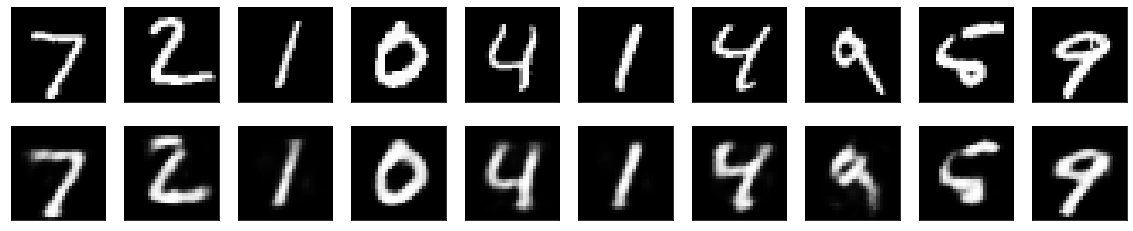

In [9]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [10]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test size (in MB): {x_test.nbytes/1024**2:.2f}")
print(f"encoded_imgs size (in MB): {encoded_imgs.nbytes/1024**2:.2f}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test size (in MB): 29.91
encoded_imgs size (in MB): 1.22
Compression ratio: 1/25


## 6. Deep AutoEncoder

We can easily expand our model to be a deep autoencoder by adding some hidden layers. All we have to do is add a parameter `hidden_layer_sizes` and use it in `_keras_build_fn` to build hidden layers.
For simplicity, we use a single `hidden_layer_sizes` parameter and mirror it across the encoding layers and decoding layers, but there is nothing forcing us to build symetrical models.

In [11]:
from typing import List


class DeepAutoEncoder(AutoEncoder):
    """A class that enables transform and fit_transform.
    """
    
    def _keras_build_fn(self, encoding_dim: int, hidden_layer_sizes: List[str], meta: Dict[str, Any]):
        n_features_in = meta["n_features_in_"]

        encoder_input = keras.Input(shape=(n_features_in,))
        x = encoder_input
        for layer_size in hidden_layer_sizes:
            x = keras.layers.Dense(layer_size, activation='relu')(x)
        encoder_output = keras.layers.Dense(encoding_dim, activation='relu')(x)
        encoder_model = keras.Model(encoder_input, encoder_output)

        decoder_input = keras.Input(shape=(encoding_dim,))
        x = decoder_input
        for layer_size in reversed(hidden_layer_sizes):
            x = keras.layers.Dense(layer_size, activation='relu')(x)
        decoder_output = keras.layers.Dense(n_features_in, activation='sigmoid', name="decoder")(x)
        decoder_model = keras.Model(decoder_input, decoder_output)

        autoencoder_input = keras.Input(shape=(n_features_in,))
        encoded_img = encoder_model(autoencoder_input)
        reconstructed_img = decoder_model(encoded_img)

        autoencoder_model = keras.Model(autoencoder_input, reconstructed_img)

        self.encoder_model_ = BaseWrapper(encoder_model, verbose=self.verbose)
        self.decoder_model_ = BaseWrapper(decoder_model, verbose=self.verbose)

        return autoencoder_model

In [12]:
deep = DeepAutoEncoder(
    loss="binary_crossentropy",
    encoding_dim=32,
    hidden_layer_sizes=[128, 64],
    random_state=0,
    epochs=5,
    batch_size=256,
    fit__verbose=1,
    predict__verbose=0
)
_ = deep.fit(X=x_train)

Epoch 1/5


  1/235 [..............................] - ETA: 4:40 - loss: 0.6937

  5/235 [..............................] - ETA: 3s - loss: 0.6760  

  9/235 [>.............................] - ETA: 2s - loss: 0.6224

 14/235 [>.............................] - ETA: 2s - loss: 0.5643

 19/235 [=>............................] - ETA: 2s - loss: 0.5227

 24/235 [==>...........................] - ETA: 2s - loss: 0.4921

 29/235 [==>...........................] - ETA: 2s - loss: 0.4687

 34/235 [===>..........................] - ETA: 2s - loss: 0.4501

 40/235 [====>.........................] - ETA: 2s - loss: 0.4322

 45/235 [====>.........................] - ETA: 2s - loss: 0.4200

 50/235 [=====>........................] - ETA: 2s - loss: 0.4095

 54/235 [=====>........................] - ETA: 2s - loss: 0.4021

 58/235 [======>.......................] - ETA: 2s - loss: 0.3955

 63/235 [=======>......................] - ETA: 1s - loss: 0.3880

 68/235 [=======>......................] - ETA: 1s - loss: 0.3813

 73/235 [========>.....................] - ETA: 1s - loss: 0.3752

 78/235 [========>.....................] - ETA: 1s - loss: 0.3697

 83/235 [=========>....................] - ETA: 1s - loss: 0.3646

 88/235 [==========>...................] - ETA: 1s - loss: 0.3599

 93/235 [==========>...................] - ETA: 1s - loss: 0.3555

 98/235 [===========>..................] - ETA: 1s - loss: 0.3514

103/235 [============>.................] - ETA: 1s - loss: 0.3475

108/235 [============>.................] - ETA: 1s - loss: 0.3439

112/235 [=============>................] - ETA: 1s - loss: 0.3411

116/235 [=============>................] - ETA: 1s - loss: 0.3385

120/235 [==============>...............] - ETA: 1s - loss: 0.3360

125/235 [==============>...............] - ETA: 1s - loss: 0.3329

130/235 [===============>..............] - ETA: 1s - loss: 0.3301

134/235 [================>.............] - ETA: 1s - loss: 0.3279

139/235 [================>.............] - ETA: 1s - loss: 0.3253

143/235 [=================>............] - ETA: 1s - loss: 0.3233

148/235 [=================>............] - ETA: 1s - loss: 0.3208

153/235 [==================>...........] - ETA: 0s - loss: 0.3185

157/235 [===================>..........] - ETA: 0s - loss: 0.3167

162/235 [===================>..........] - ETA: 0s - loss: 0.3146

166/235 [====================>.........] - ETA: 0s - loss: 0.3129

170/235 [====================>.........] - ETA: 0s - loss: 0.3113

175/235 [=====================>........] - ETA: 0s - loss: 0.3093

180/235 [=====================>........] - ETA: 0s - loss: 0.3074

185/235 [======================>.......] - ETA: 0s - loss: 0.3056

190/235 [=======================>......] - ETA: 0s - loss: 0.3039

194/235 [=======================>......] - ETA: 0s - loss: 0.3025

199/235 [========================>.....] - ETA: 0s - loss: 0.3009

204/235 [=========================>....] - ETA: 0s - loss: 0.2993

209/235 [=========================>....] - ETA: 0s - loss: 0.2977

214/235 [==========================>...] - ETA: 0s - loss: 0.2962

218/235 [==========================>...] - ETA: 0s - loss: 0.2950

223/235 [===========================>..] - ETA: 0s - loss: 0.2936

228/235 [============================>.] - ETA: 0s - loss: 0.2922

232/235 [============================>.] - ETA: 0s - loss: 0.2911

235/235 [==============================] - 4s 12ms/step - loss: 0.2900


Epoch 2/5
  1/235 [..............................] - ETA: 3s - loss: 0.1791

  6/235 [..............................] - ETA: 2s - loss: 0.1792

 11/235 [>.............................] - ETA: 2s - loss: 0.1791

 16/235 [=>............................] - ETA: 2s - loss: 0.1787

 21/235 [=>............................] - ETA: 2s - loss: 0.1785

 26/235 [==>...........................] - ETA: 2s - loss: 0.1784

 31/235 [==>...........................] - ETA: 2s - loss: 0.1784

 35/235 [===>..........................] - ETA: 2s - loss: 0.1783

 39/235 [===>..........................] - ETA: 2s - loss: 0.1782

 43/235 [====>.........................] - ETA: 2s - loss: 0.1781

 48/235 [=====>........................] - ETA: 2s - loss: 0.1780

 53/235 [=====>........................] - ETA: 2s - loss: 0.1779

 57/235 [======>.......................] - ETA: 2s - loss: 0.1778

 62/235 [======>.......................] - ETA: 2s - loss: 0.1776

 67/235 [=======>......................] - ETA: 2s - loss: 0.1775

 72/235 [========>.....................] - ETA: 2s - loss: 0.1774

 76/235 [========>.....................] - ETA: 1s - loss: 0.1772

 81/235 [=========>....................] - ETA: 1s - loss: 0.1771

 86/235 [=========>....................] - ETA: 1s - loss: 0.1770

 91/235 [==========>...................] - ETA: 1s - loss: 0.1769

 96/235 [===========>..................] - ETA: 1s - loss: 0.1767

100/235 [===========>..................] - ETA: 1s - loss: 0.1766

104/235 [============>.................] - ETA: 1s - loss: 0.1765

108/235 [============>.................] - ETA: 1s - loss: 0.1764

112/235 [=============>................] - ETA: 1s - loss: 0.1763

116/235 [=============>................] - ETA: 1s - loss: 0.1762

120/235 [==============>...............] - ETA: 1s - loss: 0.1761

123/235 [==============>...............] - ETA: 1s - loss: 0.1760

127/235 [===============>..............] - ETA: 1s - loss: 0.1759

131/235 [===============>..............] - ETA: 1s - loss: 0.1758

135/235 [================>.............] - ETA: 1s - loss: 0.1757

138/235 [================>.............] - ETA: 1s - loss: 0.1756

142/235 [=================>............] - ETA: 1s - loss: 0.1755

147/235 [=================>............] - ETA: 1s - loss: 0.1754

151/235 [==================>...........] - ETA: 1s - loss: 0.1753

156/235 [==================>...........] - ETA: 1s - loss: 0.1752

160/235 [===================>..........] - ETA: 0s - loss: 0.1751

164/235 [===================>..........] - ETA: 0s - loss: 0.1750

168/235 [====================>.........] - ETA: 0s - loss: 0.1749

173/235 [=====================>........] - ETA: 0s - loss: 0.1748

177/235 [=====================>........] - ETA: 0s - loss: 0.1747

181/235 [======================>.......] - ETA: 0s - loss: 0.1746

185/235 [======================>.......] - ETA: 0s - loss: 0.1745

190/235 [=======================>......] - ETA: 0s - loss: 0.1744

194/235 [=======================>......] - ETA: 0s - loss: 0.1743

199/235 [========================>.....] - ETA: 0s - loss: 0.1741

204/235 [=========================>....] - ETA: 0s - loss: 0.1740

209/235 [=========================>....] - ETA: 0s - loss: 0.1739

213/235 [==========================>...] - ETA: 0s - loss: 0.1738

217/235 [==========================>...] - ETA: 0s - loss: 0.1737

221/235 [===========================>..] - ETA: 0s - loss: 0.1736

225/235 [===========================>..] - ETA: 0s - loss: 0.1735

229/235 [============================>.] - ETA: 0s - loss: 0.1734

234/235 [============================>.] - ETA: 0s - loss: 0.1733

235/235 [==============================] - 3s 13ms/step - loss: 0.1733


Epoch 3/5
  1/235 [..............................] - ETA: 2s - loss: 0.1600

  6/235 [..............................] - ETA: 2s - loss: 0.1601

 11/235 [>.............................] - ETA: 2s - loss: 0.1592

 16/235 [=>............................] - ETA: 2s - loss: 0.1588

 21/235 [=>............................] - ETA: 2s - loss: 0.1585

 25/235 [==>...........................] - ETA: 2s - loss: 0.1584

 30/235 [==>...........................] - ETA: 2s - loss: 0.1584

 35/235 [===>..........................] - ETA: 2s - loss: 0.1583

 40/235 [====>.........................] - ETA: 2s - loss: 0.1581

 45/235 [====>.........................] - ETA: 2s - loss: 0.1580

 50/235 [=====>........................] - ETA: 2s - loss: 0.1579

 55/235 [======>.......................] - ETA: 2s - loss: 0.1578

 60/235 [======>.......................] - ETA: 2s - loss: 0.1578

 65/235 [=======>......................] - ETA: 2s - loss: 0.1577

 69/235 [=======>......................] - ETA: 2s - loss: 0.1576

 74/235 [========>.....................] - ETA: 1s - loss: 0.1575

 79/235 [=========>....................] - ETA: 1s - loss: 0.1575

 84/235 [=========>....................] - ETA: 1s - loss: 0.1574

 88/235 [==========>...................] - ETA: 1s - loss: 0.1573

 93/235 [==========>...................] - ETA: 1s - loss: 0.1572

 97/235 [===========>..................] - ETA: 1s - loss: 0.1572

102/235 [============>.................] - ETA: 1s - loss: 0.1571

106/235 [============>.................] - ETA: 1s - loss: 0.1570

110/235 [=============>................] - ETA: 1s - loss: 0.1569

115/235 [=============>................] - ETA: 1s - loss: 0.1569

120/235 [==============>...............] - ETA: 1s - loss: 0.1568

124/235 [==============>...............] - ETA: 1s - loss: 0.1567

129/235 [===============>..............] - ETA: 1s - loss: 0.1566

133/235 [===============>..............] - ETA: 1s - loss: 0.1565

137/235 [================>.............] - ETA: 1s - loss: 0.1565

142/235 [=================>............] - ETA: 1s - loss: 0.1564

146/235 [=================>............] - ETA: 1s - loss: 0.1563

150/235 [==================>...........] - ETA: 1s - loss: 0.1563

154/235 [==================>...........] - ETA: 1s - loss: 0.1562

158/235 [===================>..........] - ETA: 0s - loss: 0.1561

162/235 [===================>..........] - ETA: 0s - loss: 0.1561

166/235 [====================>.........] - ETA: 0s - loss: 0.1560

170/235 [====================>.........] - ETA: 0s - loss: 0.1559

174/235 [=====================>........] - ETA: 0s - loss: 0.1559

179/235 [=====================>........] - ETA: 0s - loss: 0.1558

184/235 [======================>.......] - ETA: 0s - loss: 0.1557

188/235 [=======================>......] - ETA: 0s - loss: 0.1556

192/235 [=======================>......] - ETA: 0s - loss: 0.1556

197/235 [========================>.....] - ETA: 0s - loss: 0.1555

202/235 [========================>.....] - ETA: 0s - loss: 0.1554

207/235 [=========================>....] - ETA: 0s - loss: 0.1554

212/235 [==========================>...] - ETA: 0s - loss: 0.1553

217/235 [==========================>...] - ETA: 0s - loss: 0.1552

222/235 [===========================>..] - ETA: 0s - loss: 0.1552

227/235 [===========================>..] - ETA: 0s - loss: 0.1551

231/235 [============================>.] - ETA: 0s - loss: 0.1550

235/235 [==============================] - 3s 12ms/step - loss: 0.1550


Epoch 4/5
  1/235 [..............................] - ETA: 2s - loss: 0.1447

  6/235 [..............................] - ETA: 2s - loss: 0.1454

 10/235 [>.............................] - ETA: 2s - loss: 0.1455

 15/235 [>.............................] - ETA: 2s - loss: 0.1453

 20/235 [=>............................] - ETA: 2s - loss: 0.1454

 24/235 [==>...........................] - ETA: 2s - loss: 0.1455

 29/235 [==>...........................] - ETA: 2s - loss: 0.1454

 34/235 [===>..........................] - ETA: 2s - loss: 0.1454

 38/235 [===>..........................] - ETA: 2s - loss: 0.1454

 43/235 [====>.........................] - ETA: 2s - loss: 0.1453

 47/235 [=====>........................] - ETA: 2s - loss: 0.1453

 51/235 [=====>........................] - ETA: 2s - loss: 0.1452

 56/235 [======>.......................] - ETA: 2s - loss: 0.1452

 60/235 [======>.......................] - ETA: 2s - loss: 0.1452

 64/235 [=======>......................] - ETA: 2s - loss: 0.1451

 68/235 [=======>......................] - ETA: 2s - loss: 0.1451

 72/235 [========>.....................] - ETA: 2s - loss: 0.1451

 77/235 [========>.....................] - ETA: 1s - loss: 0.1450

 81/235 [=========>....................] - ETA: 1s - loss: 0.1450

 86/235 [=========>....................] - ETA: 1s - loss: 0.1449

 90/235 [==========>...................] - ETA: 1s - loss: 0.1449

 95/235 [===========>..................] - ETA: 1s - loss: 0.1449

 99/235 [===========>..................] - ETA: 1s - loss: 0.1448

103/235 [============>.................] - ETA: 1s - loss: 0.1448

108/235 [============>.................] - ETA: 1s - loss: 0.1447

112/235 [=============>................] - ETA: 1s - loss: 0.1447

116/235 [=============>................] - ETA: 1s - loss: 0.1447

121/235 [==============>...............] - ETA: 1s - loss: 0.1446

125/235 [==============>...............] - ETA: 1s - loss: 0.1446

129/235 [===============>..............] - ETA: 1s - loss: 0.1446

133/235 [===============>..............] - ETA: 1s - loss: 0.1445

138/235 [================>.............] - ETA: 1s - loss: 0.1445

142/235 [=================>............] - ETA: 1s - loss: 0.1445

146/235 [=================>............] - ETA: 1s - loss: 0.1444

150/235 [==================>...........] - ETA: 1s - loss: 0.1444

155/235 [==================>...........] - ETA: 1s - loss: 0.1444

159/235 [===================>..........] - ETA: 0s - loss: 0.1443

164/235 [===================>..........] - ETA: 0s - loss: 0.1443

169/235 [====================>.........] - ETA: 0s - loss: 0.1442

173/235 [=====================>........] - ETA: 0s - loss: 0.1442

177/235 [=====================>........] - ETA: 0s - loss: 0.1442

181/235 [======================>.......] - ETA: 0s - loss: 0.1441

186/235 [======================>.......] - ETA: 0s - loss: 0.1441

191/235 [=======================>......] - ETA: 0s - loss: 0.1440

195/235 [=======================>......] - ETA: 0s - loss: 0.1440

199/235 [========================>.....] - ETA: 0s - loss: 0.1440

203/235 [========================>.....] - ETA: 0s - loss: 0.1439

207/235 [=========================>....] - ETA: 0s - loss: 0.1439

211/235 [=========================>....] - ETA: 0s - loss: 0.1439

216/235 [==========================>...] - ETA: 0s - loss: 0.1438

221/235 [===========================>..] - ETA: 0s - loss: 0.1438

226/235 [===========================>..] - ETA: 0s - loss: 0.1438

231/235 [============================>.] - ETA: 0s - loss: 0.1437

235/235 [==============================] - 3s 13ms/step - loss: 0.1437


Epoch 5/5
  1/235 [..............................] - ETA: 2s - loss: 0.1366

  6/235 [..............................] - ETA: 2s - loss: 0.1355

 11/235 [>.............................] - ETA: 2s - loss: 0.1355

 15/235 [>.............................] - ETA: 2s - loss: 0.1357

 19/235 [=>............................] - ETA: 2s - loss: 0.1360

 24/235 [==>...........................] - ETA: 2s - loss: 0.1363

 29/235 [==>...........................] - ETA: 2s - loss: 0.1364

 33/235 [===>..........................] - ETA: 2s - loss: 0.1365

 37/235 [===>..........................] - ETA: 2s - loss: 0.1365

 42/235 [====>.........................] - ETA: 2s - loss: 0.1365

 46/235 [====>.........................] - ETA: 2s - loss: 0.1366

 51/235 [=====>........................] - ETA: 2s - loss: 0.1366

 55/235 [======>.......................] - ETA: 2s - loss: 0.1366

 60/235 [======>.......................] - ETA: 2s - loss: 0.1366

 65/235 [=======>......................] - ETA: 2s - loss: 0.1366

 70/235 [=======>......................] - ETA: 2s - loss: 0.1366

 75/235 [========>.....................] - ETA: 2s - loss: 0.1366

 79/235 [=========>....................] - ETA: 1s - loss: 0.1366

 83/235 [=========>....................] - ETA: 1s - loss: 0.1366

 88/235 [==========>...................] - ETA: 1s - loss: 0.1366

 93/235 [==========>...................] - ETA: 1s - loss: 0.1366

 97/235 [===========>..................] - ETA: 1s - loss: 0.1366

102/235 [============>.................] - ETA: 1s - loss: 0.1366

107/235 [============>.................] - ETA: 1s - loss: 0.1366

111/235 [=============>................] - ETA: 1s - loss: 0.1366

116/235 [=============>................] - ETA: 1s - loss: 0.1366

120/235 [==============>...............] - ETA: 1s - loss: 0.1366

124/235 [==============>...............] - ETA: 1s - loss: 0.1366

128/235 [===============>..............] - ETA: 1s - loss: 0.1365

132/235 [===============>..............] - ETA: 1s - loss: 0.1365

136/235 [================>.............] - ETA: 1s - loss: 0.1365

140/235 [================>.............] - ETA: 1s - loss: 0.1365

144/235 [=================>............] - ETA: 1s - loss: 0.1365

148/235 [=================>............] - ETA: 1s - loss: 0.1365

152/235 [==================>...........] - ETA: 1s - loss: 0.1365

156/235 [==================>...........] - ETA: 0s - loss: 0.1365

160/235 [===================>..........] - ETA: 0s - loss: 0.1364

164/235 [===================>..........] - ETA: 0s - loss: 0.1364

168/235 [====================>.........] - ETA: 0s - loss: 0.1364

173/235 [=====================>........] - ETA: 0s - loss: 0.1364

178/235 [=====================>........] - ETA: 0s - loss: 0.1364

183/235 [======================>.......] - ETA: 0s - loss: 0.1363

187/235 [======================>.......] - ETA: 0s - loss: 0.1363

192/235 [=======================>......] - ETA: 0s - loss: 0.1363

196/235 [========================>.....] - ETA: 0s - loss: 0.1363

201/235 [========================>.....] - ETA: 0s - loss: 0.1363

206/235 [=========================>....] - ETA: 0s - loss: 0.1362

211/235 [=========================>....] - ETA: 0s - loss: 0.1362

217/235 [==========================>...] - ETA: 0s - loss: 0.1362

223/235 [===========================>..] - ETA: 0s - loss: 0.1361

229/235 [============================>.] - ETA: 0s - loss: 0.1361

235/235 [==============================] - 3s 12ms/step - loss: 0.1361


   1/1875 [..............................] - ETA: 1:05

  65/1875 [>.............................] - ETA: 1s  

 116/1875 [>.............................] - ETA: 1s

 178/1875 [=>............................] - ETA: 1s

 240/1875 [==>...........................] - ETA: 1s

 280/1875 [===>..........................] - ETA: 1s



 331/1875 [====>.........................] - ETA: 1s

 379/1875 [=====>........................] - ETA: 1s

 435/1875 [=====>........................] - ETA: 1s

 495/1875 [======>.......................] - ETA: 1s

 555/1875 [=======>......................] - ETA: 1s

 615/1875 [========>.....................] - ETA: 1s

 675/1875 [=========>....................] - ETA: 1s

 734/1875 [==========>...................] - ETA: 1s

 794/1875 [===========>..................] - ETA: 0s

 855/1875 [============>.................] - ETA: 0s

 915/1875 [=============>................] - ETA: 0s

 974/1875 [==============>...............] - ETA: 0s

1033/1875 [===============>..............] - ETA: 0s

1091/1875 [================>.............] - ETA: 0s

1149/1875 [=================>............] - ETA: 0s

1210/1875 [==================>...........] - ETA: 0s

1269/1875 [===================>..........] - ETA: 0s

1329/1875 [====================>.........] - ETA: 0s

1389/1875 [=====================>........] - ETA: 0s

1435/1875 [=====================>........] - ETA: 0s

1485/1875 [======================>.......] - ETA: 0s

1541/1875 [=======================>......] - ETA: 0s

1584/1875 [========================>.....] - ETA: 0s

1639/1875 [=========================>....] - ETA: 0s

1696/1875 [==========================>...] - ETA: 0s

1739/1875 [==========================>...] - ETA: 0s

1797/1875 [===========================>..] - ETA: 0s

1858/1875 [============================>.] - ETA: 0s

1875/1875 [==============================] - 2s 907us/step


In [13]:
score = autoencoder.score(X=x_test)
print(f"AutoEncoder score on test data: {score:.3f}")

score = deep.score(X=x_test)
print(f"Deep AutoEncoder score on test data: {score:.3f}")

AutoEncoder score on test data: 0.812


Deep AutoEncoder score on test data: 0.809


Although small, we do see a slight improvement by adding some more layers.